# Comparison of two CV methods: KFold (KF) and Monte Carlo (MC)

## Imports

In [1]:
# computation
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

In [2]:
def main(N, P, K, N_STEPS, N_DATASETS):
    """
    Main function to run the simulation

    Parameters
    ----------
    N : int
        Number of samples
    P : int
        Number of features
    K : int
        Number of folds
    N_STEPS : int
        Number of steps. Each step is a complete cross-validation
        e.g., if K=5 and N_STEPS=10, there will be 50 model fitting and 10 estimates
    N_DATASETS : int
        Number of datasets to simulate
    """
    df = pd.DataFrame()
    for i in range(N_DATASETS):
        df_trial = trial(N, P, K, N_STEPS)
        df_trial['dataset'] = i
        df = pd.concat([df, df_trial], ignore_index=True)

    df_tidy = df.melt(
                id_vars=['step', 'dataset'], 
                var_name='method', 
                value_name='r')
    return df_tidy

def trial(N, P, K, N_STEPS):
    """
    return a dataframe with N_STEPS estimates
    """
    X = np.random.randn(N, P)
    y = np.random.randn(N)

    dict_scores = {
        "MC": [None] * (N_STEPS), # monte carlo
        "KF": [None] * (N_STEPS), # k-fold
    }

    for method in dict_scores.keys():
        for i in range(N_STEPS):
            splits = Splitter(X, y, K).sample_splits(method)
            scores = [None] * K
            for k in range(K):
                scores[k] = estimate_g(splits[k])
            dict_scores[method][i] = np.mean(scores)
        dict_scores[method] = cum_avg(dict_scores[method])

    result = pd.DataFrame(data=dict_scores)
    result['step'] = result.index

    return result

class Splitter:
    def __init__(self, X, y, K):
        self.X = X
        self.y = y
        self.K = K
        self.n = X.shape[0]
        self.n_test = int((1 / K) * self.n)

    def sample_splits(self, method):
        if method == 'MC':
            dict_idx = self.sample_MC_idx()
        elif method == 'KF':
            dict_idx = self.sample_KF_idx()

        return self.assign_splits(dict_idx)

    def sample_MC_idx(self):
        # monte carlo validation
        dict_idx = {}
        for k in range(self.K):
            dict_idx[k] = {}
            idx_rdm = np.random.permutation(self.n)
            dict_idx[k] = idx_rdm[:self.n_test]

        return dict_idx

    def sample_KF_idx(self):
        # k-fold cross-validation
        idx_rdm = np.random.permutation(self.n)
        dict_idx = np.array_split(idx_rdm, self.K)
        
        return dict_idx

    def assign_splits(self, dict_idx):
        dict_splits = {}
        set_idx = set(range(self.n))

        for k in range(self.K):
            dict_splits[k] = {}

            idx_test = dict_idx[k]
            idx_train = list(set_idx - set(idx_test))

            dict_splits[k]['X_train'] = self.X[idx_train]
            dict_splits[k]['X_test'] = self.X[idx_test]
            dict_splits[k]['y_train'] = self.y[idx_train]
            dict_splits[k]['y_test'] = self.y[idx_test]

        return dict_splits


def estimate_g(split):
    """
    Estimate generalization performance in correlation coefficient
    """
    X_train, X_test = split['X_train'], split['X_test']
    y_train, y_test = split['y_train'], split['y_test']
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r, _ = pearsonr(y_test, y_pred)
    return r 

def cum_avg(arr):
    """
    Calculate cumulative average
    """
    return np.cumsum(arr) / np.arange(1, len(arr) + 1)

def plotting(out):
    plt.figure(figsize=(10, 5))
    plt.axhline(
        np.median(out["r"]),  # median estimates as converging point
        color='black', 
        linestyle='--', 
        linewidth=1,)
    sns.lineplot(
        data=out,
        x='step',
        y='r', 
        hue='method',
        estimator="median",)
    plt.xlabel('Number of estimates')
    plt.ylabel('Bias in r')
    plt.show()


## CONSTANTS

In [3]:
N = 500 # number of samples
P = 10 # number of features

## Experiments

### K=2

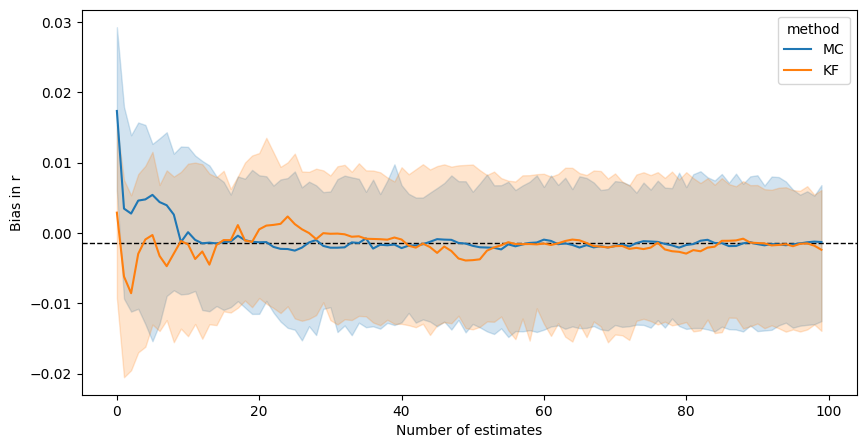

In [4]:
out = main(N, P, K=2, N_STEPS=100, N_DATASETS=100)
plotting(out)

### K=5

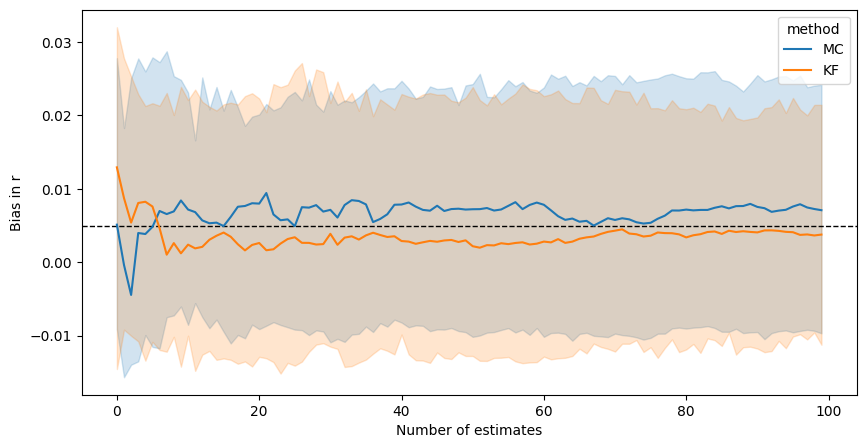

In [5]:
out = main(N, P, K=5, N_STEPS=100, N_DATASETS=100)
plotting(out)

## K=10

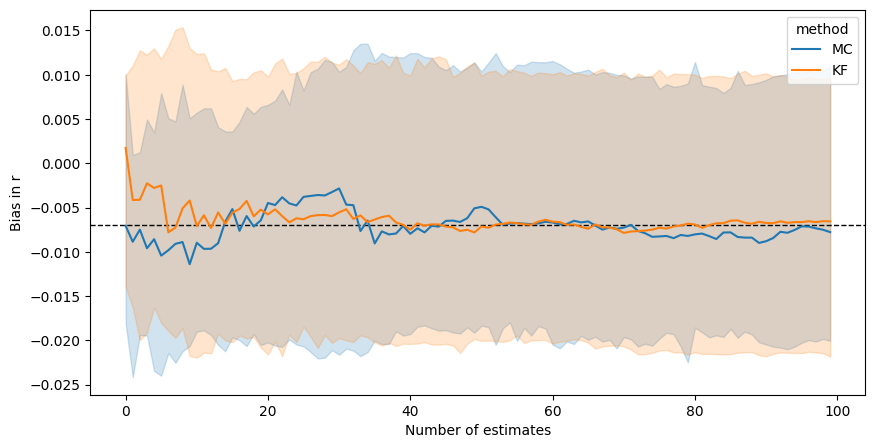

In [6]:
out = main(N, P, K=10, N_STEPS=100, N_DATASETS=100)
plotting(out)